In [7]:
#Load up names.txt
words = open('names.txt', 'r').read().split('\n')

In [8]:
import torch
import torch.nn.functional as F
import numpy as np
import plotly.graph_objs as go

In [9]:
#Get a list of all the chars
chars = ['.'] + sorted(list(set(''.join(words))))

#Tokenize the text- This will be used to convert the text to numbers
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

In [10]:
#Build data set
vocab_size = len(chars)
block_size = 3

def build_data_set(words):
    #Get the inputs and targets
    X, Y = [], []

    for word in words[:]:
        word = "." + word + "."
        context = [0] * block_size
        for i in range(len(word)-1):
            chr = char_to_idx[word[i]]
            context.append(chr)
            if len(context) > block_size:
                context = context[1:]
            X.append(context[:])
            Y.append(char_to_idx[word[i+1]])

            # print("For context", context, "predict", word[i+1])

    #Convert to tensor
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

import random
random.seed(42)

#Shuffle the data
random.shuffle(words)

n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

X_train, Y_train = build_data_set(words[:n1])
X, Y = build_data_set(words[:n1]) #Just for prev code
X_val, Y_val = build_data_set(words[n1:n2])
X_test, Y_test = build_data_set(words[n2:])
print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))


Train: 182625 Val: 22655 Test: 22866


In [11]:
emb_dim = 10
hidden_size = 200
batch_size = 32 
n = 10000

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn(len(chars), emb_dim, generator=g)
W1 = torch.randn(emb_dim*block_size, hidden_size, generator=g) * (5/3)/np.sqrt(emb_dim*block_size)
b1 = torch.randn(hidden_size, generator=g) * .01
W2 = torch.randn(hidden_size, len(chars), generator=g)*0.01
b2 = torch.randn(len(chars), generator=g)*0

bngain = torch.ones((1, hidden_size))
bnbias = torch.zeros((1,hidden_size))

bnmean_running = torch.ones((1, hidden_size))
bnstd_running = torch.zeros((1,hidden_size))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad_()



In [12]:
n = 10000
batch_size = 32
lr = .001

In [14]:
for i in range(n):
    #Mini-batch
    ix = torch.randint(len(X_train), (batch_size,))

    emb = C[X_train[ix]]
    emb = emb.view(len(X_train[ix]), -1) #len(X_train) x (block_size*2)
    hpreact = emb @ W1
    #Batch norm
    mean = hpreact.mean(0, keepdim=True)
    var = hpreact.var(0, keepdim=True)
    hpreact = (hpreact - mean) / torch.sqrt(var + 1e-8)
    hpreact = hpreact * bngain + bnbias

    #Now update the running mean and stddev to move in the direction of the batch's mean and stddev
    with torch.no_grad():
        bnmean_running = .9 * bnmean_running + .1 * mean
        bnstd_running = .9 * bnstd_running + .1 * var

    h = torch.tanh(hpreact) #Apply activation function
    logits = h @ W2 + b2 #len(X_train) x len(chars)
    loss = F.cross_entropy(logits, Y[ix]) #This is the same as the above 4 lines 
    

    #Backward Pass
    for p in parameters:
        p.grad = None

    loss.backward()

    #Update parameters
    #Disable gradient tracking (for efficiency)
    with torch.no_grad():
        for p in parameters:
            p.data -= lr * p.grad





TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [ ]:
#Calculate batch norm after training
emb = C[X_train]
emb = emb.view(len(X_train), -1) #len(X_train) x (block_size*2)
hpreact = emb @ W1 #+ b1
#Batch norm
mean = hpreact.mean(0, keepdim=True)
var = hpreact.var(0, keepdim=True)

#Print mean and stddev of hpreact and compare to the batch norm running mean and stddev
mean = hpreact.mean(0)[0].item()
stddev = hpreact.std(0)[0].item()
print("Method 1 Mean:", mean, "Stddev:", stddev)
print("Method 2 Mean:", bnmean_running[0][0].item(), "Stddev:", torch.sqrt(bnstd_running[0][0]).item())

#Print the percent difference between the two methods
print("Percent difference (Mean):", 100 * (mean - bnmean_running[0][0].item()) / bnmean_running[0][0].item())
print("Percent difference (Stddev):", 100 * (stddev - torch.sqrt(bnstd_running[0][0]).item()) / torch.sqrt(bnstd_running[0][0]).item())

Method 1 Mean: -0.5559956431388855 Stddev: 1.741192102432251
Method 2 Mean: -0.5310854315757751 Stddev: 1.6845917701721191
Percent difference (Mean): 4.690433983323485
Percent difference (Stddev): 3.3598841726710345


In [ ]:
#Calculate loss of validation set
emb = C[X_val]
emb = emb.view(len(X_val), -1) #len(X_val) x (block_size*2)
hpreact = emb @ W1 #+ b1
#Batch norm
hpreact = (hpreact - bnmean_running) / torch.sqrt(bnstd_running + 1e-8)
hpreact = hpreact * bngain + bnbias
h = torch.tanh(hpreact) #Apply activation function
logits = h @ W2 + b2 #len(X_val) x len(chars)
loss = F.cross_entropy(logits, Y_val) #This is the same as the above 4 lines
print("Validation Loss: ", loss.item())

#Calculate loss of Training set
emb = C[X_train]
emb = emb.view(len(X_train), -1) #len(X_train) x (block_size*2)
h = emb @ W1 #+ b1 #len(X_train) x hidden_size
h = torch.tanh(h) #Apply activation function
logits = h @ W2 + b2 #len(X_train) x len(chars)
loss = F.cross_entropy(logits, Y_train) #This is the same as the above 4 lines
print("Training Loss: ", loss.item()) 

#Training Loss is close to Validation Loss so we are not overfitting. 

Validation Loss:  2.67166805267334
Training Loss:  2.729121208190918


In [ ]:
#Mini-batch
ix = torch.randint(len(X_train), (batch_size,))

emb = C[X_train[ix]]
emb = emb.view(len(X_train[ix]), -1) #len(X_train) x (block_size*2)
h = emb @ W1 #+ b1 #len(X_train) x hidden_size
h = torch.tanh(h) #Apply activation function

#Plot histogram of h values
h = h.detach().numpy().flatten()

fig = go.Figure(data=[go.Histogram(x=h)])
fig.show()

In [ ]:
x = torch.randn(1000,10)
w = torch.randn(10,200)/10**.5
y = x @ w

#Print mean and standard deviation of x compared to y (2 decimal places)
print("x mean:", round(x.mean().item(),2), "std:", round(x.std().item(),2))
print("y mean:", round(y.mean().item(),2), "std:", round(y.std().item(),2))

x mean: -0.01 std: 1.0
y mean: 0.0 std: 1.0


## Pytorchifying the code

In [ ]:
#Create a Linear Layer Class
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(fan_in, fan_out) / fan_in**.5
        self.bias = torch.zeros(fan_out) if bias else None
        self.params = [self.weight] + ([self.bias] if bias else [])

    def __call__(self, x):
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return self.params

#Create a Linear Layer Class to test
linear = Linear(10, 200, False)

x = torch.randn(1000,10)
y = linear(x)

In [ ]:
#Creating the Batch Normalization Layer 
class BatchNorm1d: 
    def __init__(self,dim,eps=1e-5,momentum=.1):
        self.eps = eps
        self.momentum = momentum
        self.dim = dim
        # self.weight = torch.ones(dim) #Gain
        # self.bias = torch.zeros(dim) #Bias
        self.weight = torch.ones(dim) #Gain
        self.bias = torch.zeros(dim) #Bias
    

        self.params = [self.weight,self.bias]
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

        self.training = True

    def __call__(self,x):
        #Calculate Forward Pass
        if self.training:
            #Use batch mean
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else: 
            #Use running mean
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) #Make it a gaussian (mean 0, std 1)
        self.out = self.weight * xhat + self.bias #Scale and shiftA

        #Update running mean and variance
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * xmean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar + (1 - self.momentum) * self.running_var

        return self.out

    def parameters(self):
        return self.params 

In [ ]:
class Tanh:
    def __init__(self):
        self.params = []

    def __call__(self, x):
        self.out = x.tanh()
        return self.out

    def parameters(self): 
        return self.params

In [ ]:
import torch.nn as nn

In [ ]:
#Convert the model to use the new layers

n_embd = 10 
n_hidden=  100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn(len(chars), n_embd, generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), #Remembers block size is the amount of context we are using
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, n_hidden, False),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, n_hidden, False),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, n_hidden, False),
    BatchNorm1d(n_hidden),
    Tanh(),
    
    Linear(n_hidden, len(chars)),
    BatchNorm1d(len(chars)),
]

#Change the initialization of the weights like we did before 
with torch.no_grad():
    #Last Layer should be initialized close to 0
    layers[-1].weight *= 0.1
    layers[-1].bias.zero_()
    # layers[-1].gamma *= 0.1
    # layers[-1].beta.zero_()

    #Apply Kaiming Initialization to all other layers
    for l in layers[:-1]:
        if isinstance(l, Linear):
            l.weight *= 5/3
    
#Get all the parameters of the model
parameters = [C] + [p for l in layers for p in l.parameters()]
for p in parameters:
    p.requires_grad = True

In [ ]:
max_steps = 2000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    #Get the minibatch
    ix = torch.randint(len(X_train), (batch_size,), generator=g)
    x, y = X_train[ix], Y_train[ix]

    #Forward Pass
    #First embed the characters
    emb = C[x]
    x = emb.view(len(x), -1) #len(X_train) x (block_size*2)

    #Then pass through the layers
    for l in layers:
        x = l(x)
    loss = F.cross_entropy(x, y)


    #Backward Pass
    for l in layers:
        l.out.retain_grad() #Tell pytorch to keep the gradient of the output of the layer so we can use it later in our debugging
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = .01 if i < 150E3 else .01
    # lr = 1e-3
    for p in parameters:
        p.data -= lr * p.grad

    #Track stats every once in a while
    if i % 100 == 0:
        print(f'step: {i:5d}, loss: {loss.item():0.4f}')

    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters]) #Track the ratio of the gradient norm to the parameter norm

    
    lossi.append(loss.log10().item())

    # break


    

    


step:     0, loss: 3.3026
step:   100, loss: 3.0038
step:   200, loss: 2.7726
step:   300, loss: 2.5247
step:   400, loss: 2.6988
step:   500, loss: 2.4140
step:   600, loss: 2.1941
step:   700, loss: 2.5276
step:   800, loss: 2.4316
step:   900, loss: 2.2330
step:  1000, loss: 2.4634
step:  1100, loss: 2.4044
step:  1200, loss: 2.4898
step:  1300, loss: 2.4179
step:  1400, loss: 2.4206
step:  1500, loss: 2.3949
step:  1600, loss: 2.5048
step:  1700, loss: 2.5156
step:  1800, loss: 2.3431
step:  1900, loss: 2.4162


Text(0.5, 1.0, 'activation distribution')

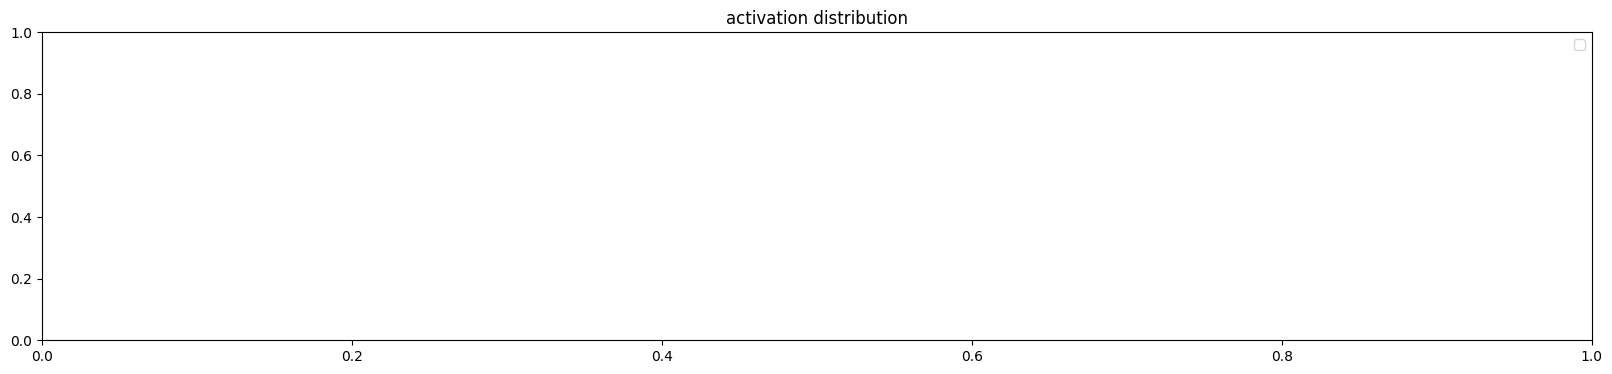

In [ ]:
import matplotlib.pyplot as plt

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


layer 1 (      Tanh): mean -0.000024, std 7.842590e-04
layer 3 (      Tanh): mean -0.000015, std 5.738824e-04
layer 5 (      Tanh): mean +0.000002, std 4.035204e-04
layer 7 (      Tanh): mean -0.000006, std 3.012999e-04


Text(0.5, 1.0, 'gradient distribution')

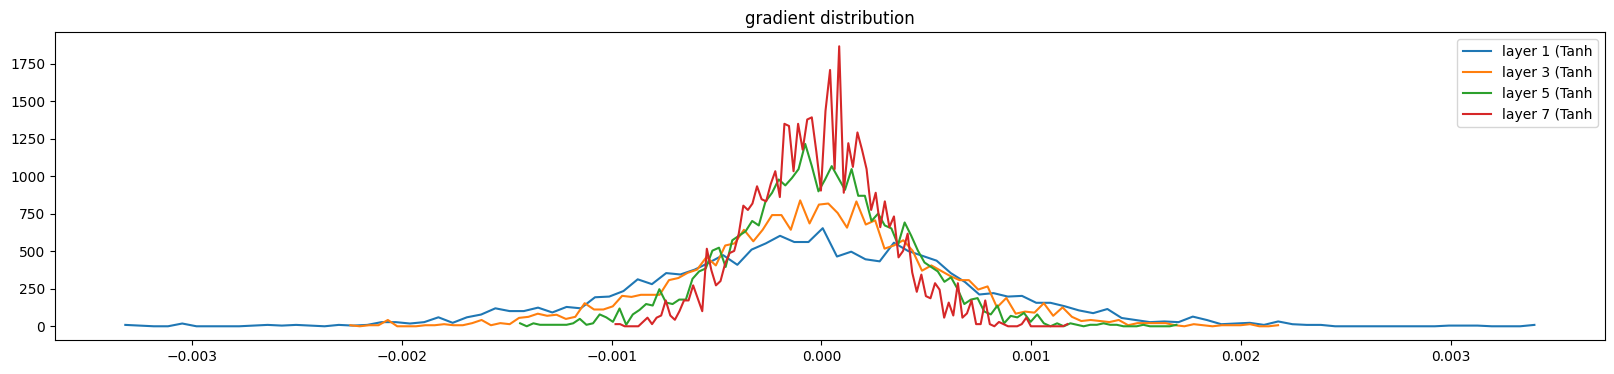

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')


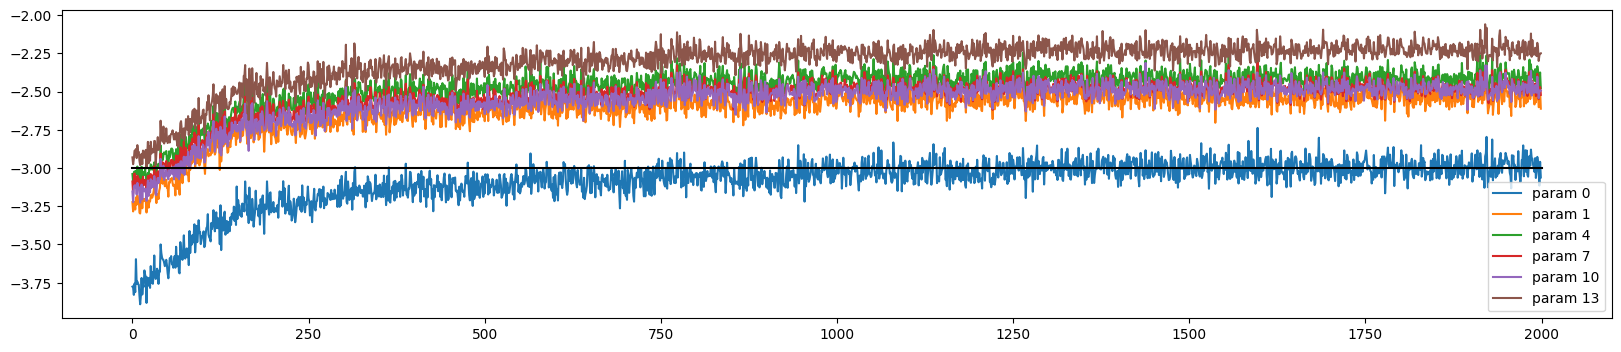

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [ ]:
hy.shape

torch.Size([100])

In [ ]:
hx.shape

torch.Size([101])

In [ ]:
hx[:-1].detach().shape

torch.Size([100])

In [ ]:
t.shape

torch.Size([32, 100])

# Becoming a Backpropagation Ninja

In [310]:
#Create a utiltity function to compare the gradiants calculated by us and the gradients calculated by pytorch

def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [16]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [17]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(len(X_train), (batch_size,), generator=g)
Xb, Yb = X_train[ix], Y_train[ix]

In [312]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()

loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.7014, grad_fn=<NegBackward0>)

In [323]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

# -----------------
# YOUR CODE HERE :)
# -----------------

dlogprobs = -F.one_hot(Yb,num_classes=vocab_size)/len(Yb)
cmp('logprobs', dlogprobs, logprobs)
dprobs = 1/probs*dlogprobs
cmp('probs', dprobs, probs)
dcounts_sum_inv = (counts*dprobs).sum(1,keepdim=True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
dcounts_sum = -counts_sum**-2*dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)
dcounts = (torch.ones(32,27)*dcounts_sum)+counts_sum_inv*dprobs
cmp('counts', dcounts, counts)
dnorm_logits = counts*dcounts
cmp('norm_logits', dnorm_logits, norm_logits)
dlogit_maxes = dnorm_logits.sum(1,keepdim=True)*-1
cmp('logit_maxes', dlogit_maxes, logit_maxes)
dlogits = dnorm_logits#-dlogit_maxes
dlogits += torch.where(logits == logit_maxes, 1, 0)*dlogit_maxes
cmp('logits', dlogits, logits)

# dh_list = []
# for y in range(32):
#     dh_row = []
#     for x in range(64):
#         dlogRow = dlogits[y]
#         W2_row = W2[x]

#         val = torch.sum(dlogRow*W2_row).item()
#         dh_row.append(val)

#     dh_list.append(torch.tensor(dh_row))

# dh = torch.stack(dh_list)
dh = dlogits@W2.T

cmp('h', dh, h)

# dW2_list = []
# for y in range(64):
#     dW2_row = []
#     for x in range(27):
#         hCol = h[:,y]
#         dlogCol = dlogits[:,x]

#         val = torch.sum(hCol*dlogCol).item()
#         dW2_row.append(val)
    
#     dW2_list.append(torch.tensor(dW2_row))
        

# dW2 = torch.stack(dW2_list)
dW2 = h.T@dlogits

cmp('W2', dW2, W2)

db2 = torch.sum(dlogits,dim=0)
cmp('b2', db2, b2)
dhpreact = (1 - torch.tanh(hpreact)**2)*dh
cmp('hpreact', dhpreact, hpreact)
dbngain = torch.sum(bnraw*dhpreact,dim=0,keepdim=True)
cmp('bngain', dbngain, bngain)
dbnbias = torch.sum(dhpreact,dim=0,keepdim=True)
cmp('bnbias', dbnbias, bnbias)
dbnraw = bngain*dhpreact
cmp('bnraw', dbnraw, bnraw)
dbnvar_inv = torch.sum(dbnraw*bndiff,dim=0,keepdim=True)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
dbnvar = -.5*(bnvar+1e-5)**-1.5*dbnvar_inv
cmp('bnvar', dbnvar, bnvar)
dbndiff2 = (1/(n-1))*torch.ones_like(bndiff2)*dbnvar
cmp('bndiff2', dbndiff2, bndiff2)
dbndiff = dbnraw*bnvar_inv
dbndiff += 2*bndiff*dbndiff2
cmp('bndiff', dbndiff, bndiff)
dbnmeani = -dbndiff.sum(0,keepdim=True)
cmp('bnmeani', dbnmeani, bnmeani)
dhprebn = dbndiff
dhprebn += (1/(n))*torch.ones_like(hprebn)*dbnmeani#torch.broadcast_to(dbnmeani, (32,64))
cmp('hprebn', dhprebn, hprebn)
dembcat = dhprebn@W1.T
cmp('embcat', dembcat, embcat)
dW1 = embcat.T@dhprebn
cmp('W1', dW1, W1)
db1 = dhprebn.sum(0,keepdim=True)
cmp('b1', db1, b1)
demb = dembcat.view((32,3,10))
cmp('emb', demb, emb)
dC = torch.zeros(27,10)

for i,indexes in enumerate(Xb):
    vals_i = demb[i]
    for j,index in enumerate(indexes): 
        dC[index] += vals_i[j]
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [314]:
dbnvar.shape

torch.Size([1, 200])

In [316]:
bndiff2.shape

torch.Size([32, 200])

In [20]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3421099185943604 diff: 0.0


In [81]:
logits.grad[0][Yb[0]]-dlogits[0][Yb[0]]

tensor(-0.0312, grad_fn=<SubBackward0>)

In [96]:
logits.grad[0][Yb[0]]

tensor(-0.0307)

In [71]:
logits_sums = logits.exp().sum(1,keepdim=True)
logits_sums.shape

torch.Size([32, 1])

In [111]:
dlogits = torch.zeros_like(logits)
for i, example in enumerate(logits): 
    dlogits[i] = (logits_sums[i])**-1*example.exp()*32**-1

    i_y = Yb[i]
    v_y = example[i_y].exp()
    dlogits[i][i_y] = -(logits_sums[i]-v_y)*logits_sums[i]**-1*32**-1
    # dlogits[i][i_y] -= 32**-1

dlogits[0][Yb[0]]


tensor(-0.0307, grad_fn=<SelectBackward0>)

In [112]:
# backward pass

# -----------------
# YOUR CODE HERE :)
# -----------------

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09


In [238]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [200]:
(((hprebn-u)**2).sum(dim=1)/63).shape

torch.Size([32])

In [244]:
do2

tensor([[-0.0647, -0.1002,  0.0817,  ...,  0.2228, -0.0567,  0.0432],
        [-0.1389,  0.0034, -0.1199,  ..., -0.0553,  0.0140, -0.0596],
        [-0.0746,  0.0666,  0.1368,  ...,  0.0580, -0.0940,  0.0446],
        ...,
        [ 0.0076, -0.0148,  0.0179,  ..., -0.0372,  0.0045,  0.0575],
        [-0.1086, -0.1317,  0.0936,  ...,  0.0616,  0.1379, -0.1461],
        [ 0.1807, -0.0164, -0.0119,  ..., -0.0776, -0.1739, -0.0475]],
       grad_fn=<MulBackward0>)

In [274]:
hpreact.shape

torch.Size([32, 64])

In [275]:
dn.shape

torch.Size([32, 64])

In [273]:
hprebn.shape

torch.Size([32, 64])

In [286]:
bngain.shape

torch.Size([1, 64])

In [297]:
du = torch.ones_like(hprebn)/n
u = hprebn.mean(dim=0,keepdim=True)
o2 = hprebn.var(dim=0,keepdim=True,unbiased=True)
do2 = (hprebn-u)*(2/(n-1))

num = hprebn-u
den = (o2+1e-5)**.5
dnum = 1-du
dden = .5*(o2+1e-5)**-.5*do2

dxhat = (dnum*den - num*dden)/den**2
dn = bngain*dxhat

dhprebn = dhpreact*dn

In [298]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
# dhprebn = None # TODO. my solution is 1 (long) line
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: False | maxdiff: 0.0014677798608317971


In [299]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([64]))

In [303]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27
torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [331]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
#with torch.no_grad():

# kick off optimization
for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hprebn = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmean = hprebn.mean(0, keepdim=True)
  bnvar = hprebn.var(0, keepdim=True, unbiased=True)
  bnvar_inv = (bnvar + 1e-5)**-0.5
  bnraw = (hprebn - bnmean) * bnvar_inv
  hpreact = bngain * bnraw + bnbias
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward() # use this for correctness comparisons, delete it later!

  # manual backprop! #swole_doge_meme
  # -----------------
  # YOUR CODE HERE :)
  dC, dW1, db1, dW2, db2, dbngain, dbnbias = None, None, None, None, None, None, None

  dlogprobs = -F.one_hot(Yb,num_classes=vocab_size)/len(Yb)
  dprobs = 1/probs*dlogprobs
  dcounts_sum_inv = (counts*dprobs).sum(1,keepdim=True)
  dcounts_sum = -counts_sum**-2*dcounts_sum_inv
  dcounts = (torch.ones(32,27)*dcounts_sum)+counts_sum_inv*dprobs
  dnorm_logits = counts*dcounts
  dlogit_maxes = dnorm_logits.sum(1,keepdim=True)*-1
  dlogits = dnorm_logits#-dlogit_maxes
  dlogits += torch.where(logits == logit_maxes, 1, 0)*dlogit_maxes
  dh = dlogits@W2.T
  dW2 = h.T@dlogits
  db2 = torch.sum(dlogits,dim=0)
  dhpreact = (1 - torch.tanh(hpreact)**2)*dh
  dbngain = torch.sum(bnraw*dhpreact,dim=0,keepdim=True)
  dbnbias = torch.sum(dhpreact,dim=0,keepdim=True)
  dbnraw = bngain*dhpreact
  dbnvar_inv = torch.sum(dbnraw*bndiff,dim=0,keepdim=True)
  dbnvar = -.5*(bnvar+1e-5)**-1.5*dbnvar_inv
  dbndiff2 = (1/(n-1))*torch.ones_like(bndiff2)*dbnvar
  dbndiff = dbnraw*bnvar_inv
  dbndiff += 2*bndiff*dbndiff2
  dbnmeani = -dbndiff.sum(0,keepdim=True)
  dhprebn = dbndiff
  dhprebn += (1/(n))*torch.ones_like(hprebn)*dbnmeani#torch.broadcast_to(dbnmeani, (32,64))
  dembcat = dhprebn@W1.T
  dW1 = embcat.T@dhprebn
  db1 = dhprebn.sum(0,keepdim=True)
  demb = dembcat.view((32,3,10))
  dC = torch.zeros(27,10)

  for i_,indexes in enumerate(Xb):
      vals_i = demb[i_]
      for j,index in enumerate(indexes): 
          dC[index] += vals_i[j]


  grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
  # -----------------A

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p, grad in zip(parameters, grads):
    p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
    #p.data += -lr * grad # new way of swole doge TODO: enable

  # track stats
  if i % 1000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #   break

12297
      0/ 200000: 3.7349
   1000/ 200000: 2.1302
   2000/ 200000: 2.2891
   3000/ 200000: 2.4572
   4000/ 200000: 2.6556
   5000/ 200000: 2.1938


KeyboardInterrupt: 